### ISSUES

1. One image may have both dark and light backgrounds and the threshold cannot cover that unless I implement another algorithm
and not the current lazy ass one (if black pixels > 40% invert)
2. Some images are still rather unreadable but it's due to the original quality being bad from the start.


In [1]:
%pip install scikit-image
%pip install matplotlib
%pip install cv2
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
from skimage import io, filters, transform, img_as_ubyte, img_as_float, color
from skimage.filters import unsharp_mask, threshold_local, threshold_otsu
import matplotlib.pyplot as plt
from skimage import data
import numpy as np
from skimage.morphology import erosion, disk

def threshold_images(input_folder, output_folder, s=None, t=None):
    """ 
    notes: resizing messed up the image pretty badly so i commented it out, 
    this and ignore the lossy compression wearnings, converting the image 
    also destroys most clarity and the results will be very different from what is shown here
    
    This function reads images from the input folder, processes them with thresholding,
    and saves the binarized images to the output folder.
    
    """

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Read the image
            img_path = os.path.join(input_folder, filename)
            image = io.imread(img_path, as_gray=True)
            original = io.imread(img_path, as_gray=True)

            # Define the size of the structuring element (kernel)
            # structuring_element = disk(2)  # Adjust the size as needed

            # Apply erosion to the processed image
            # image = erosion(image, structuring_element)
            
            # Calculate the number of black pixels
            black_pixels = np.sum(image < 50 / 255.0)  # Convert threshold to range 0-1
            total_pixels = image.size
            black_percentage = black_pixels / total_pixels * 100
            # print(black_percentage)

            # Check if the image is majority black
            if black_percentage > 40:
                # # Invert the image by subtracting each pixel value from 255
                # image = 1.0 - image  # Invert the image

                # bradley whatever
                # Convert image to numpy array
                img = np.array(image).astype(float)

                # Default window size is round(cols/8)
                if s is None:
                    s = np.round(img.shape[1]/8)

                # Default threshold is 15% of the total
                # area in the window
                if t is None:
                    t = 15.0

                # Compute integral image
                intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

                # Define grid of points
                (rows,cols) = img.shape[:2]
                (X,Y) = np.meshgrid(np.arange(cols), np.arange(rows))

                # Make into 1D grid of coordinates for easier access
                X = X.ravel()
                Y = Y.ravel()

                # Ensure s is even so that we are able to index into the image
                # properly
                s = s + np.mod(s,2)

                # Access the four corners of each neighbourhood
                x1 = X - s/2
                x2 = X + s/2
                y1 = Y - s/2
                y2 = Y + s/2

                # Ensure no coordinates are out of bounds
                x1[x1 < 0] = 0
                x2[x2 >= cols] = cols-1
                y1[y1 < 0] = 0
                y2[y2 >= rows] = rows-1

                # Ensures coordinates are integer
                x1 = x1.astype(int)
                x2 = x2.astype(int)
                y1 = y1.astype(int)
                y2 = y2.astype(int)

                # Count how many pixels are in each neighbourhood
                count = (x2 - x1) * (y2 - y1)

                # Compute the row and column coordinates to access
                # each corner of the neighbourhood for the integral image
                f1_x = x2
                f1_y = y2
                f2_x = x2
                f2_y = y1 - 1
                f2_y[f2_y < 0] = 0
                f3_x = x1-1
                f3_x[f3_x < 0] = 0
                f3_y = y2
                f4_x = f3_x
                f4_y = f2_y

                # Compute areas of each window
                sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

                # Compute thresholded image and reshape into a 2D grid
                out = np.ones(rows*cols, dtype=bool)
                out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False

                # Also convert back to uint8
                image = 255*np.reshape(out, (rows, cols)).astype(np.uint8)
                # image = 1.0 - image 


            # Apply adaptive thresholding, doing two types here and comparing the performance
            global_thresh = threshold_otsu(image)
            binary_global = image > global_thresh

            block_size = 3
            offset = 0.0000001
            thresh_meth = 'gaussian'
            image = threshold_local(image, block_size, thresh_meth, offset)


            # Apply unsharp masking filter for sharpening
            # Parameters:
            # - radius: The radius of the Gaussian blur used for the unsharp masking (larger values mean stronger blur)
            # - amount: The strength of the sharpening (higher values mean stronger sharpening)
            image = filters.unsharp_mask(image, radius=3, amount=3.5)
            binary_global = filters.unsharp_mask(binary_global, radius=3, amount=3.5)

            # if black_percentage > 40:
            #     # Display the variations
            #     fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
            #     ax0, ax1, ax2 = axes
            #     plt.gray()

            #     ax0.imshow(original)
            #     ax0.set_title('Original Image')

            #     ax1.imshow(binary_global)
            #     ax1.set_title('Global thresholding')

            #     ax2.imshow(image)
            #     ax2.set_title('Adaptive thresholding')

            #     for ax in axes:
            #         ax.axis('off')

            #     plt.show()
            #     img = img_as_ubyte(binary_global)
            #     cv2.imshow("image", img)


            # Save thresholded image to output folder
            output_path = os.path.join(output_folder, filename)
            io.imsave(output_path, img_as_ubyte(image))

input_folder = 'C:/Users/jieru/Downloads/FIT3164/project/Medication-Dispensing-with-Image-Processing/Dataset_13-5-2024'
output_folder = 'C:/Users/jieru/Downloads/FIT3164/project/Medication-Dispensing-with-Image-Processing/Image Pre-Processing/adaptive thresh2'

# Apply try_all_threshold to PNG images in the input folder
threshold_images(input_folder, output_folder)

In [19]:
# without denoise
import cv2
import os

def selective_invert_folder(folder_path, output_folder_path):
  """
  This function reads pre-thresholded images from a folder, inverts images with white text on black background, 
  and saves the processed images to a new folder.
  """
  # Create the output folder if it doesn't exist
  os.makedirs(output_folder_path, exist_ok=True)  # Create folders recursively if needed
  count =0
  for filename in os.listdir(folder_path):
    if filename.endswith((".png", ".jpg", ".jpeg")):
      # Create output filename with "_inverted" suffix (optional)
      output_filename = os.path.splitext(filename)[0] + os.path.splitext(filename)[1]
      image_path = os.path.join(folder_path, filename)
      # Construct output path in the new folder
      output_path = os.path.join(output_folder_path, output_filename)

      # Read the image (assuming grayscale and thresholded)
      img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

      # Calculate foreground (white pixel) ratio
      total_pixels = img.shape[0] * img.shape[1]  # Assuming rectangular image
      white_pixel_count = cv2.countNonZero(img)
      foreground_ratio = white_pixel_count / total_pixels

      # Decide on inversion based on foreground ratio (adjust threshold as needed)
      if foreground_ratio > 0.5:  # Mostly white foreground (likely white text)
        inverted_img = cv2.bitwise_not(img)
        count += 1
      else:
        inverted_img = img  # Keep black text image unchanged

      # Save the inverted or original image to the new folder
      cv2.imwrite(output_path, inverted_img)


# Example usage
folder_path = "C:/Users/jieru/Downloads/FIT3164/project/Medication-Dispensing-with-Image-Processing/Image Pre-Processing/adaptive thresh2"
# Specify the desired output folder path (create the folder if it doesn't exist)
output_folder_path = "C:/Users/jieru/Downloads/FIT3164/project/Medication-Dispensing-with-Image-Processing/Image Pre-Processing/output_folder"
selective_invert_folder(folder_path, output_folder_path)




In [20]:
# with denoise
import cv2
import os

def selective_invert_folder(folder_path, output_folder_path):
    """
    This function reads pre-thresholded images from a folder, inverts images with white text on black background, 
    and saves the processed images to a new folder.
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)  # Create folders recursively if needed
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            # Create output filename with "_inverted" suffix (optional)
            output_filename = os.path.splitext(filename)[0] + os.path.splitext(filename)[1]
            image_path = os.path.join(folder_path, filename)
            # Construct output path in the new folder
            output_path = os.path.join(output_folder_path, output_filename)

            # Read the image (assuming grayscale and thresholded)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Denoise the image
            img = cv2.fastNlMeansDenoising(img, None, h=10, templateWindowSize=7, searchWindowSize=21)

            # Calculate foreground (white pixel) ratio
            total_pixels = img.shape[0] * img.shape[1]  # Assuming rectangular image
            white_pixel_count = cv2.countNonZero(img)
            foreground_ratio = white_pixel_count / total_pixels

            # Decide on inversion based on foreground ratio (adjust threshold as needed)
            if foreground_ratio > 0.5:  # Mostly white foreground (likely white text)
                inverted_img = cv2.bitwise_not(img)
                count += 1
            else:
                inverted_img = img  # Keep black text image unchanged

            # Save the inverted or original image to the new folder
            cv2.imwrite(output_path, inverted_img)


# Example usage
folder_path = "C:/Users/jieru/Downloads/FIT3164/project/Medication-Dispensing-with-Image-Processing/Image Pre-Processing/adaptive thresh2"
# Specify the desired output folder path (create the folder if it doesn't exist)
output_folder_path = "C:/Users/jieru/Downloads/FIT3164/project/Medication-Dispensing-with-Image-Processing/Image Pre-Processing/denoise"
selective_invert_folder(folder_path, output_folder_path)


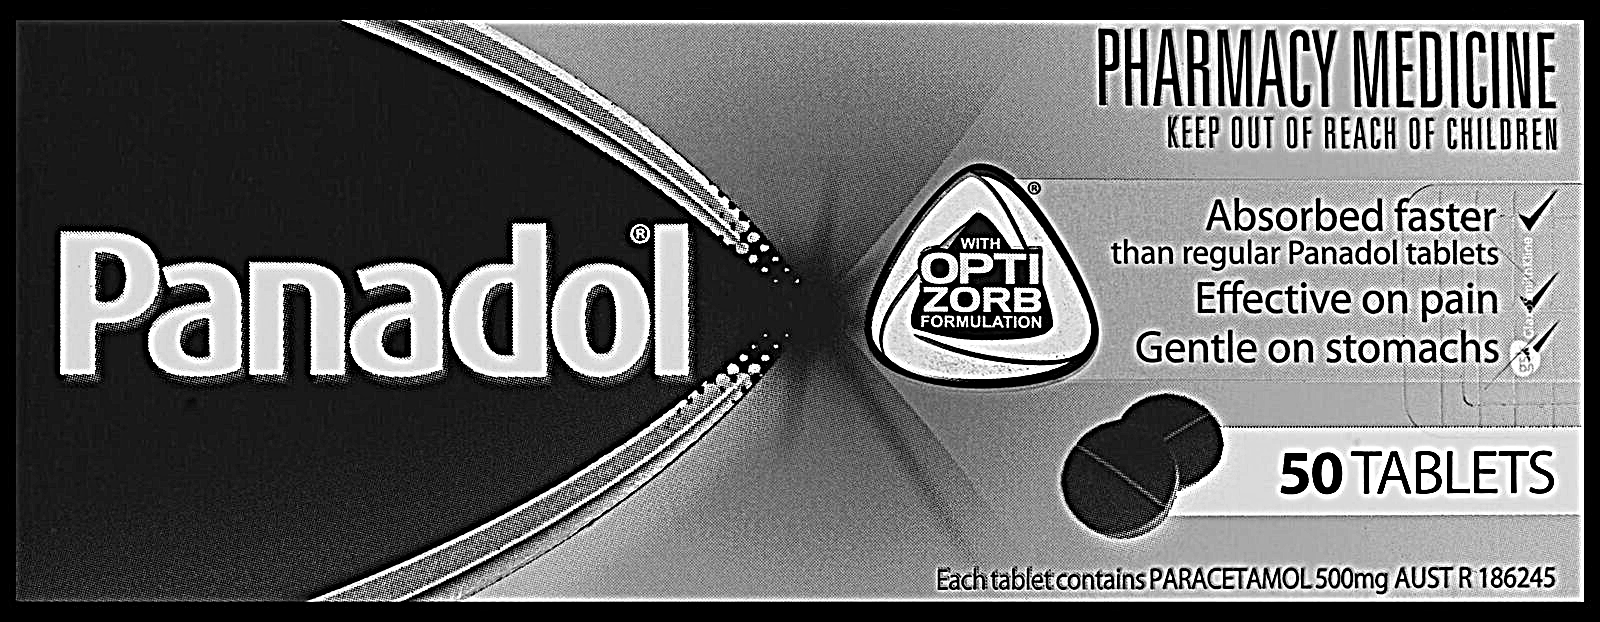

## cannot read paracetamol

In [3]:
import numpy as np
from PIL import Image

def bradley_roth_numpy(image, s=None, t=None):

    # Convert image to numpy array
    img = np.array(image).astype(float)

    # Default window size is round(cols/8)
    if s is None:
        s = np.round(img.shape[1]/8)

    # Default threshold is 15% of the total
    # area in the window
    if t is None:
        t = 15.0

    # Compute integral image
    intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

    # Define grid of points
    (rows,cols) = img.shape[:2]
    (X,Y) = np.meshgrid(np.arange(cols), np.arange(rows))

    # Make into 1D grid of coordinates for easier access
    X = X.ravel()
    Y = Y.ravel()

    # Ensure s is even so that we are able to index into the image
    # properly
    s = s + np.mod(s,2)

    # Access the four corners of each neighbourhood
    x1 = X - s/2
    x2 = X + s/2
    y1 = Y - s/2
    y2 = Y + s/2

    # Ensure no coordinates are out of bounds
    x1[x1 < 0] = 0
    x2[x2 >= cols] = cols-1
    y1[y1 < 0] = 0
    y2[y2 >= rows] = rows-1

    # Ensures coordinates are integer
    x1 = x1.astype(np.int)
    x2 = x2.astype(np.int)
    y1 = y1.astype(np.int)
    y2 = y2.astype(np.int)

    # Count how many pixels are in each neighbourhood
    count = (x2 - x1) * (y2 - y1)

    # Compute the row and column coordinates to access
    # each corner of the neighbourhood for the integral image
    f1_x = x2
    f1_y = y2
    f2_x = x2
    f2_y = y1 - 1
    f2_y[f2_y < 0] = 0
    f3_x = x1-1
    f3_x[f3_x < 0] = 0
    f3_y = y2
    f4_x = f3_x
    f4_y = f2_y

    # Compute areas of each window
    sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

    # Compute thresholded image and reshape into a 2D grid
    out = np.ones(rows*cols, dtype=np.bool)
    out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False

    # Also convert back to uint8
    out = 255*np.reshape(out, (rows, cols)).astype(np.uint8)

### References:

https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding_guide.html

https://stackoverflow.com/questions/33091755/bradley-roth-adaptive-thresholding-algorithm-how-do-i-get-better-performance

https://stackoverflow.com/questions/72555528/how-to-binarize-an-image-when-image-has-white-text-on-black-background-and-vice

#the link above gave me an anuerysm




In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, color
from skimage.morphology import disk

def experiment_erosion(input_image_path, kernel_sizes):
    """
    Function to experiment with different kernel sizes for erosion.
    
    Parameters:
        input_image_path (str): Path to the input image.
        kernel_sizes (list): List of kernel sizes (integer values) to experiment with.
    """
    # Load the input image
    image = io.imread(input_image_path, as_gray=True)

    # Create a figure for plotting
    plt.figure(figsize=(15, 10))

    # Plot the original image
    plt.subplot(1, len(kernel_sizes) + 1, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Apply erosion with different kernel sizes
    for i, size in enumerate(kernel_sizes):
        # Create a structuring element (disk) with the specified size
        structuring_element = disk(size)

        # Apply erosion to the image
        eroded_image = morphology.erosion(image, structuring_element)

        # Plot the eroded image
        plt.subplot(1, len(kernel_sizes) + 1, i + 2)
        plt.imshow(eroded_image, cmap='gray')
        plt.title(f'Kernel Size: {size}')
        plt.axis('off')

    # Display the plots
    plt.show()

# Define the path to the input image
input_image_path = 'path_to_your_image.jpg'  # Replace with the path to your image

# Define a list of kernel sizes to experiment with
kernel_sizes = [1, 2, 3, 4, 5, 6]  # Add more sizes if desired

# Call the function to experiment with erosion
experiment_erosion(input_image_path, kernel_sizes)


FileNotFoundError: No such file: 'c:\Users\jieru\Downloads\FIT3164\project\Medication-Dispensing-with-Image-Processing\Image Pre-Processing\path_to_your_image.jpg'

In [ ]:
""" i really hate this """
import tensorflow as tf 
from tensorflow.keras import layers, models

# define input shape, required?

def backbone(input_shape):
    # we use a bunch of CNN, which may need to be refined later
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Additional layers can be added as needed
    return models.Model(input_img, x)

def feature_giant(bbmodel):
    input_features = bbmodel.output
    # upsample
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_features)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    return models.Model(bbmodel.input, x)

# prediction maps
def prediction_maps(feature_giant_model):
    input_img = feature_giant_model.input
    features = feature_giant_model.output

    # Predicted probability map (binary classification)
    prob_map = layers.Conv2D(1, (1, 1), activation='sigmoid', name='prob_map')(features)
    
    # Predicted threshold map
    threshold_map = layers.Conv2D(1, (1, 1), activation='sigmoid', name='threshold_map')(features)
    
    return models.Model(input_img, [prob_map, threshold_map])

def approx_binarization(prob, threshold):
    binarized_map = tf.keras.backend.greater_equal(prob_map, threshold_map)
    return binarized_map

def binmodel(shape):
    # Create the backbone and feature giant models
    backbone_model = backbone(input_shape)
    feature_giant_model = feature_giant(backbone_model)
    
    # Create the prediction maps model
    prediction_maps_model = prediction_maps(feature_giant_model)
    
    # Define the input and outputs
    input_img = prediction_maps_model.input
    prob_map, threshold_map = prediction_maps_model.output
    
    # Calculate the binarized map
    binarized_map = approx_binarization(prob_map, threshold_map)
    
    # Create the final model
    return models.Model(input_img, [prob_map, threshold_map, binarized_map])

input_shape = (128, 128, 3)  # Adjust input shape as needed
model = binmodel(input_shape)

# Compile the model
model.compile(optimizer='adam', loss={'prob_map': 'binary_crossentropy',
                                      'threshold_map': 'mse',
                                      'binarized_map': 'binary_crossentropy'})



In [ ]:
def bounding():
    ''' dbnet algorithm used, with this hopefully we can by pass the binarization problem '''
    pass

def meat():
    pass